# Arts and culture in London

In [18]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import json
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib import colors
import numpy as np

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [6]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Get data

## Grid

Check [this notebook](https://github.com/Lisa-Ho/30-day-map-challenge/blob/main/2022/Day12/london-gridmaps.ipynb) for how to generate fishnet grids from any shapefile.

In [7]:
grid2km = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "fishnets\\london-2000-2000.geojson"))
grid1km = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "fishnets\\london-1000-1000.geojson"))

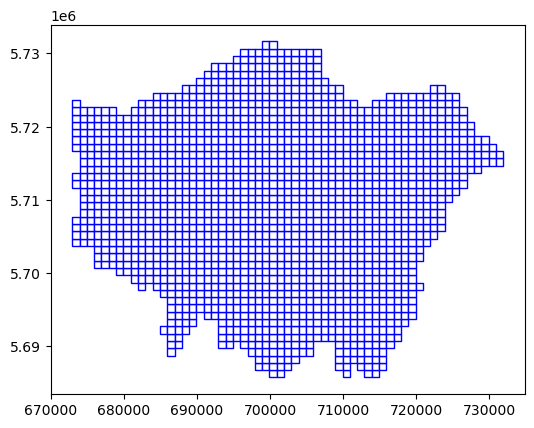

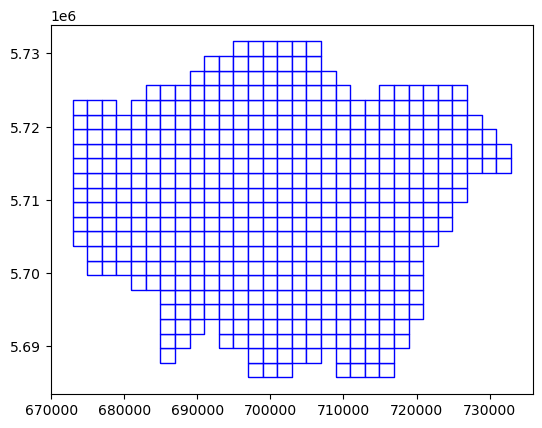

In [8]:
grid1km.plot(color="white", edgecolor="blue")
grid2km.plot(color="white", edgecolor="blue")

## Cultural venues in London

In [9]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["amenity"~"arts_centre|theatre"](area.searchArea); 
way["amenity"~"arts_centre|theatre"](area.searchArea);
rel["amenity"~"arts_centre|theatre"](area.searchArea);
node["tourism"~"museum|gallery"](area.searchArea); 
way["tourism"~"museum|gallery"](area.searchArea);
rel["tourism"~"museum|gallery"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [10]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "tourism":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "tourism", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [11]:
#create one column for type of venue
types = ["museum", "gallery", "arts_centre", "theatre"]
for _type in types:
    gdf.loc[gdf.amenity.str.contains(_type), "venue_type"] = _type
    gdf.loc[gdf.tourism.str.contains(_type), "venue_type"] = _type

In [12]:
#merge data and grid
grid = grid2km.copy()
gdf = gdf.to_crs(grid.crs)
merged = gpd.sjoin(gdf, grid, how='left')

# count venues by cell and get the most frequent type
dissolve = merged.groupby(["index_right", "venue_type"])["id"].count().to_frame().unstack()
dissolve.columns = dissolve.columns.droplevel(level=0)
dissolve["total"] = dissolve.sum(axis=1)
dissolve["main"] = "none"
for _type in types:
    dissolve.loc[dissolve[_type]/dissolve["total"] > 0.5, "main" ] = _type

# include counts and type in grid
grid.loc[dissolve.index, "total_venues"] = dissolve["total"].values
grid.loc[dissolve.index, "main_venue"] = dissolve["main"].values

# Plot

## Map in grid

In [13]:
#dictionary of places to map
places = {  "Covent\nGarden": [51.512928548426736, -0.12422115775554463]
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places = places.to_crs(grid.crs)

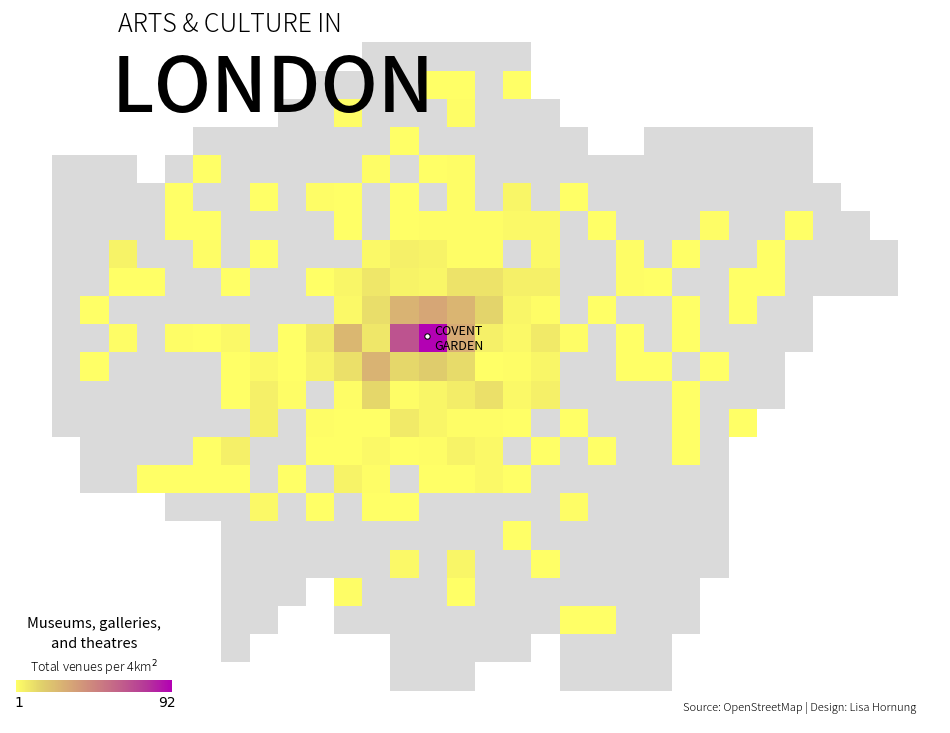

In [14]:
#configuration, colors and fonts
from palettable.scientific.sequential import Buda_7_r
cmap = Buda_7_r.mpl_colormap
bg_color = "white"

title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Regular.otf')

#plot
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(bg_color)

# ===
# Data
values = "total_venues"
grid.plot(ax=ax, column=values, alpha=1, zorder=3, cmap=cmap)
grid.plot(ax=ax, color="#DADADA",zorder=2)
places.plot(ax=ax, markersize=15, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=label_font, va="center_baseline", ha="left", fontsize=9)
ax.axis("off")

#====
#colorbar
cbaxes = fig.add_axes([0.13, 0.17, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.02,0.97])
cb.set_ticklabels(["1", int(grid[values].max())])
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 4, "Museums, galleries,\nand theatres", ha="center", fontproperties=label_font,size=10.5,
           linespacing=1.5)
cbaxes.text(0.5, 1.7, r"Total venues per 4km$^2$", ha="center", fontproperties=subtitle_font,size=9, )

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.15, "Source: OpenStreetMap | Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

plt.show()

## Other

In [19]:
#calculate center of each grid cell
grid["center"] = grid["geometry"].centroid

#filter for cells with at least one venue
centroids = grid[grid["total_venues"]>=0]

# convert to new gdf with 'centroid' as the geometry
centroids = gpd.GeoDataFrame(centroids.drop(columns="geometry"), geometry = "center")
centroids = centroids.to_crs(grid.crs)

['#F9965B', '#CCEC5A', '#5CE349', '#38B6B8', '#6E62FD', '#780085']


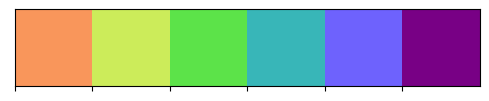

In [20]:
#get colour palette
from palettable.mycarta import Cube1_6_r
import seaborn as sns

print(Cube1_6_r.hex_colors)
sns.palplot(Cube1_6_r.hex_colors)

In [25]:
#set colours for venue type
colours = {'museum': '#5CE349', 'theatre': '#6E62FD', 'none': '#F9965B', 'gallery': '#38B6B8', 'arts_centre': '#780085'}
bg_color="#151515"
font_color="#eaeaea"

#set font styles
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\JetBrainsMono-Regular.ttf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\JetBrainsMono-Regular.ttf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\JetBrainsMono-Light.ttf')

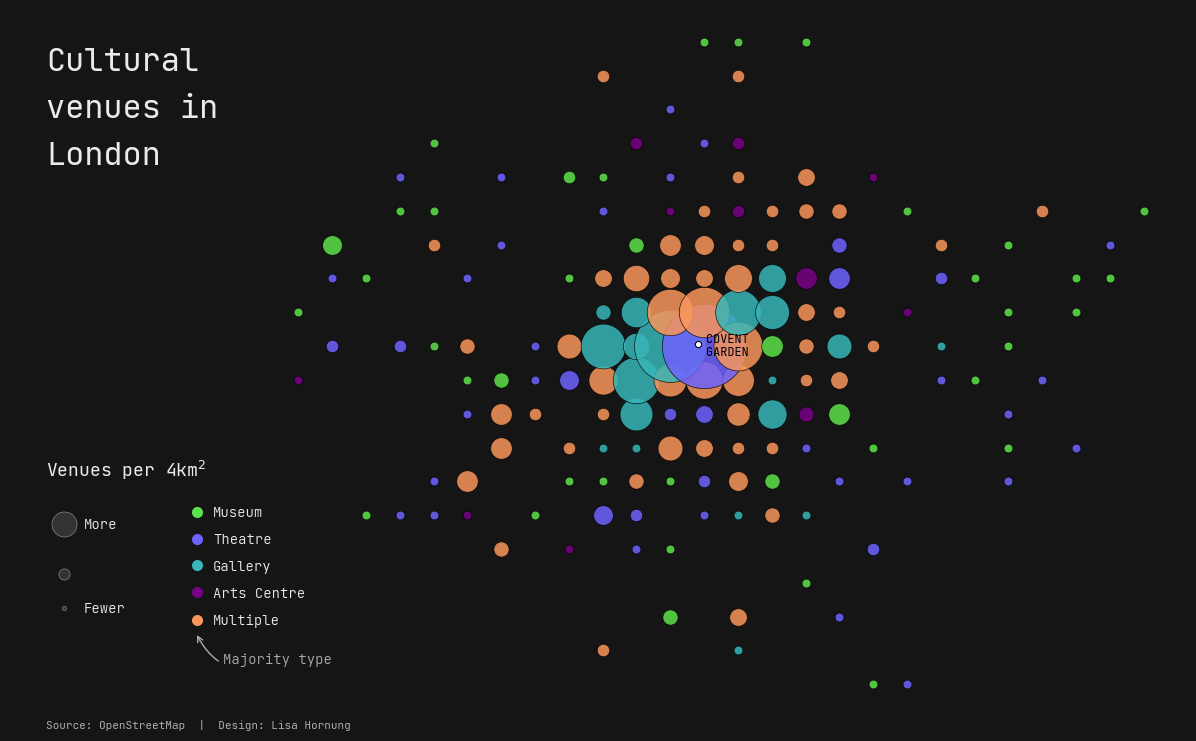

In [95]:
#plot
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["total_venues"].iloc[i]*40, marker="o", color=colours[centroids["main_venue"].iloc[i]], 
               alpha=0.85, 
               edgecolor="black", clip_on=False, linewidth=0.5)

#plot covent garden
places.plot(ax=ax, markersize=20, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=title_font, va="center_baseline", ha="left", fontsize=8.5)

## Legend
lgd1 = fig.add_axes([-0.08, 0.26, 0.13, 0.13]) 
kws = dict(marker='o', color=bg_color, markerfacecolor="#333333", markeredgecolor="#888888",markeredgewidth=0.5)
legend_elements = [Line2D([0], [0], markersize=18, label="More", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=8, label="", **kws), 
                    Line2D([0], [0], markersize=0, label="", **kws), 
                  Line2D([0], [0], markersize=3, label="Fewer", **kws)]
L = lgd1.legend(frameon=False, handles=legend_elements, loc='center', ncol=1,labelspacing=0.27, handletextpad=0.4)
plt.setp(L.texts, va="baseline", color=font_color, fontproperties=label_font,size=8,  )    

## second legend
lgd2 = fig.add_axes([0.05, 0.26, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=9, alpha=1,)
legend_elements2 = [Line2D([0], [0], markerfacecolor=colours["museum"], label="Museum", **kw), 
                  Line2D([0], [0], markerfacecolor=colours["theatre"], label="Theatre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["gallery"],label="Gallery",**kw),
                  Line2D([0], [0], markerfacecolor=colours["arts_centre"],label="Arts Centre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["none"],label="Multiple", **kw),]
L = lgd2.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=1)
plt.setp(L.texts,  va="baseline",color=font_color, fontproperties=label_font,size=8, )    
lgd2.annotate('Majority type', xy=(0.19, 0.08), xycoords='data', xytext=(20, -20), textcoords='offset points', 
                   fontsize=10, fontproperties=label_font, ha='left', va='center', annotation_clip=False,color="#ababab",
                    arrowprops=dict(arrowstyle="->",edgecolor="#ababab", connectionstyle="arc3,rad=-.5"))

#====
# Text
plt.figtext(-0.05, 0.66 , "Cultural\nvenues in\nLondon", fontproperties=subtitle_font, fontsize=23,  ha="left",
           color=font_color, linespacing=1.8)
plt.figtext(-0.05, 0.4, r"Venues per 4km$^2$", ha="left", fontproperties=title_font,size=13, color=font_color)
plt.figtext(-0.05, 0.19, "Source: OpenStreetMap  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, 
            ha="left",color="#ababab")

for axes in fig.axes:
    axes.axis("off")

#export
plt.savefig("cultural-venues-london-bubbles.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

## Arts and culture - playground

In [17]:
#calculate center of each grid cell
grid["center"] = grid["geometry"].centroid

#filter for cells with at least one venue
centroids = grid[grid["total_venues"]>=0]

# convert to new gdf with 'centroid' as the geometry
centroids = gpd.GeoDataFrame(centroids.drop(columns="geometry"), geometry = "center")
centroids = centroids.to_crs(grid.crs)

In [160]:
import random

#get random shape
shapes = [ "o", "s", "^", "D", "_", "|"]
random.choices(shapes, weights=(20, 20, 20, 20, 2,2), k=1)
gdf_arts["shape"] = random.choices(shapes, weights=(20, 20, 20, 20, 2,2), k=len(gdf_arts))

#get random colour
gdf_arts["colour"] = random.choices(Cube1_6_r.hex_colors, k=len(gdf_arts))

C:\Users\lisa.hornung\anaconda3\envs\py3_map\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\lisa.hornung\anaconda3\envs\py3_map\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [161]:
# convert to new gdf with 'centroid' as the geometry
centroids = gpd.GeoDataFrame(gdf_arts.drop(columns="geometry"), geometry = "center")
centroids = centroids.to_crs(grid.crs)

['#F9965B', '#CCEC5A', '#5CE349', '#38B6B8', '#6E62FD', '#780085']


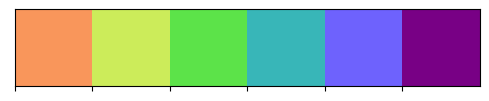

In [162]:
from palettable.mycarta import Cube1_6_r
import seaborn as sns

print(Cube1_6_r.hex_colors)
sns.palplot(Cube1_6_r.hex_colors)

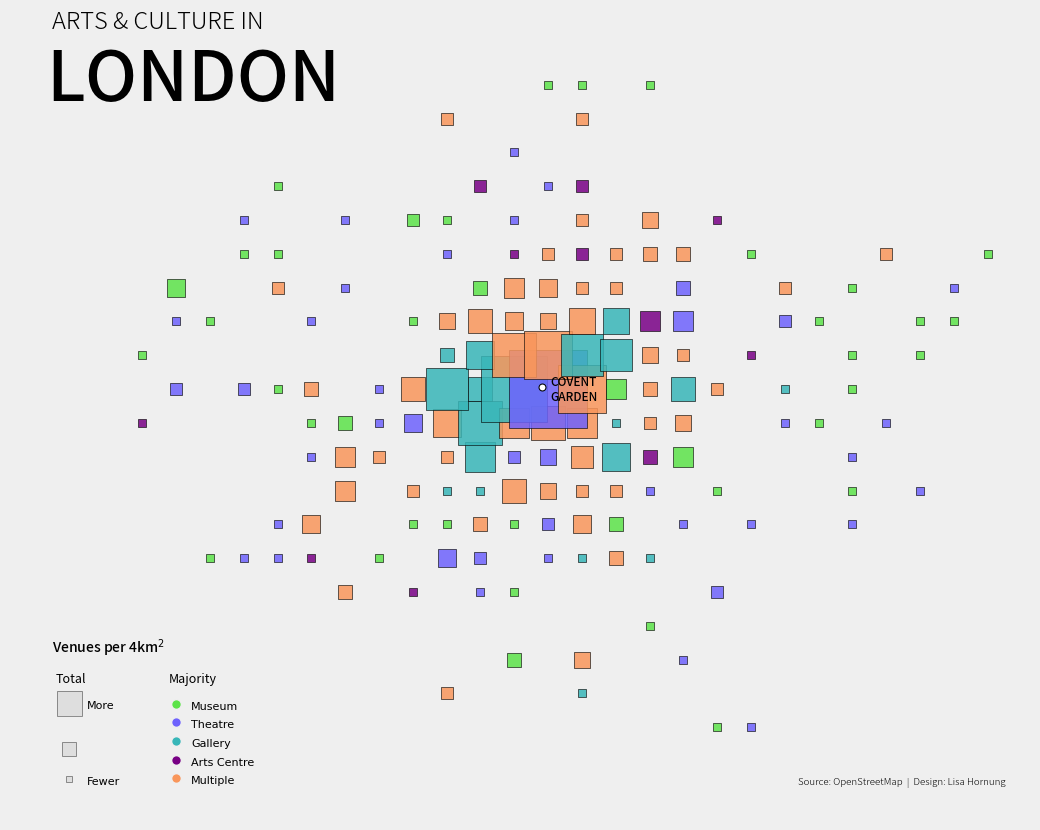

In [348]:
#plot
fig, ax = plt.subplots(figsize=(12, 12))

bg_color= "#EFEFEF"
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["total_venues"].iloc[i]*35, marker="s", color=colours[centroids["main_venue"].iloc[i]], 
               alpha=0.85, 
               edgecolor="black", clip_on=False, linewidth=0.5)

#plot covent garden
places.plot(ax=ax, markersize=25, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=title_font, va="center_baseline", ha="left", fontsize=8.5)

## Legend
lgd1 = fig.add_axes([0.15, 0.15, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=7, alpha=1,)
legend_elements = [Line2D([0], [0], markerfacecolor=colours["museum"], label="Museum", **kw), 
                  Line2D([0], [0], markerfacecolor=colours["theatre"], label="Theatre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["gallery"],label="Gallery",**kw),
                  Line2D([0], [0], markerfacecolor=colours["arts_centre"],label="Arts Centre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["none"],label="Multiple", **kw),]
L = lgd1.legend(frameon=False, handles=legend_elements, loc='center', ncol=1, handletextpad=0.1)
plt.setp(L.texts,  size=8, va="baseline")    
lgd1.text(0.4, 0.885, "Majority", fontproperties=label_font, fontsize=9,  ha="center")

## second legend
lgd2 = fig.add_axes([0.05, 0.15, 0.13, 0.13]) 
kws = dict(marker='s', color=bg_color, markerfacecolor="#DEDEDE", markeredgecolor="#888888",markeredgewidth=0.7)
legend_elements2 = [Line2D([0], [0], markersize=18, label="More", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=10, label="", **kws), 
                    Line2D([0], [0], markersize=0, label="", **kws), 
                  Line2D([0], [0], markersize=4, label="Fewer", **kws)]
L = lgd2.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1,labelspacing=0.25, handletextpad=0.3)
plt.setp(L.texts, size=8, va="baseline")    
lgd2.text(0.29, 0.885, "Total", fontproperties=label_font, fontsize=9,  ha="left")

#====
# Text
plt.figtext(0.085, 0.96-0.15 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=17,  ha="left")
plt.figtext(0.08, 0.9-0.15, "London".upper(), fontproperties=title_font, fontsize=50,  ha="left")
plt.figtext(0.88, 0.18, "Source: OpenStreetMap  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=7, ha="right")
plt.figtext(0.085, 0.29, r"Venues per 4km$^2$", ha="left", fontproperties=title_font,size=10, )

for axes in fig.axes:
    axes.axis("off")

#export
plt.savefig("london-arts-culture-creative.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

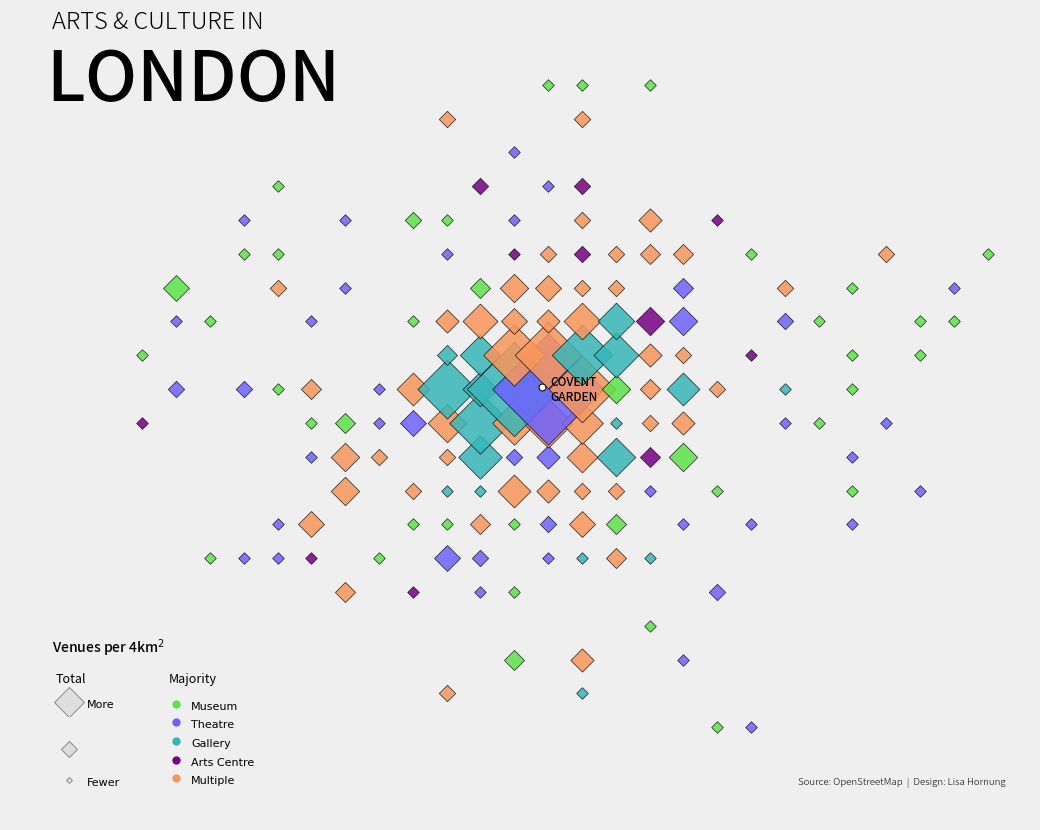

In [352]:
#plot
fig, ax = plt.subplots(figsize=(12, 12))

bg_color= "#EFEFEF"
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["total_venues"].iloc[i]*35, marker="D", color=colours[centroids["main_venue"].iloc[i]], 
               alpha=0.85, 
               edgecolor="black", clip_on=False, linewidth=0.5)

#plot covent garden
places.plot(ax=ax, markersize=25, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=title_font, va="center_baseline", ha="left", fontsize=8.5)

## Legend
lgd1 = fig.add_axes([0.15, 0.15, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=7, alpha=1,)
legend_elements = [Line2D([0], [0], markerfacecolor=colours["museum"], label="Museum", **kw), 
                  Line2D([0], [0], markerfacecolor=colours["theatre"], label="Theatre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["gallery"],label="Gallery",**kw),
                  Line2D([0], [0], markerfacecolor=colours["arts_centre"],label="Arts Centre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["none"],label="Multiple", **kw),]
L = lgd1.legend(frameon=False, handles=legend_elements, loc='center', ncol=1, handletextpad=0.1)
plt.setp(L.texts,  size=8, va="baseline")    
lgd1.text(0.4, 0.885, "Majority", fontproperties=label_font, fontsize=9,  ha="center")

## second legend
lgd2 = fig.add_axes([0.05, 0.15, 0.13, 0.13]) 
kws = dict(marker='D', color=bg_color, markerfacecolor="#DEDEDE", markeredgecolor="#888888",markeredgewidth=0.7)
legend_elements2 = [Line2D([0], [0], markersize=15, label="More", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=8, label="", **kws), 
                    Line2D([0], [0], markersize=0, label="", **kws), 
                  Line2D([0], [0], markersize=3, label="Fewer", **kws)]
L = lgd2.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1,labelspacing=0.27, handletextpad=0.3)
plt.setp(L.texts, size=8, va="baseline")    
lgd2.text(0.29, 0.885, "Total", fontproperties=label_font, fontsize=9,  ha="left")

#====
# Text
plt.figtext(0.085, 0.96-0.15 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=17,  ha="left")
plt.figtext(0.08, 0.9-0.15, "London".upper(), fontproperties=title_font, fontsize=50,  ha="left")
plt.figtext(0.88, 0.18, "Source: OpenStreetMap  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=7, ha="right")
plt.figtext(0.085, 0.29, r"Venues per 4km$^2$", ha="left", fontproperties=title_font,size=10, )

for axes in fig.axes:
    axes.axis("off")

#export
plt.savefig("london-arts-culture-creative-D.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

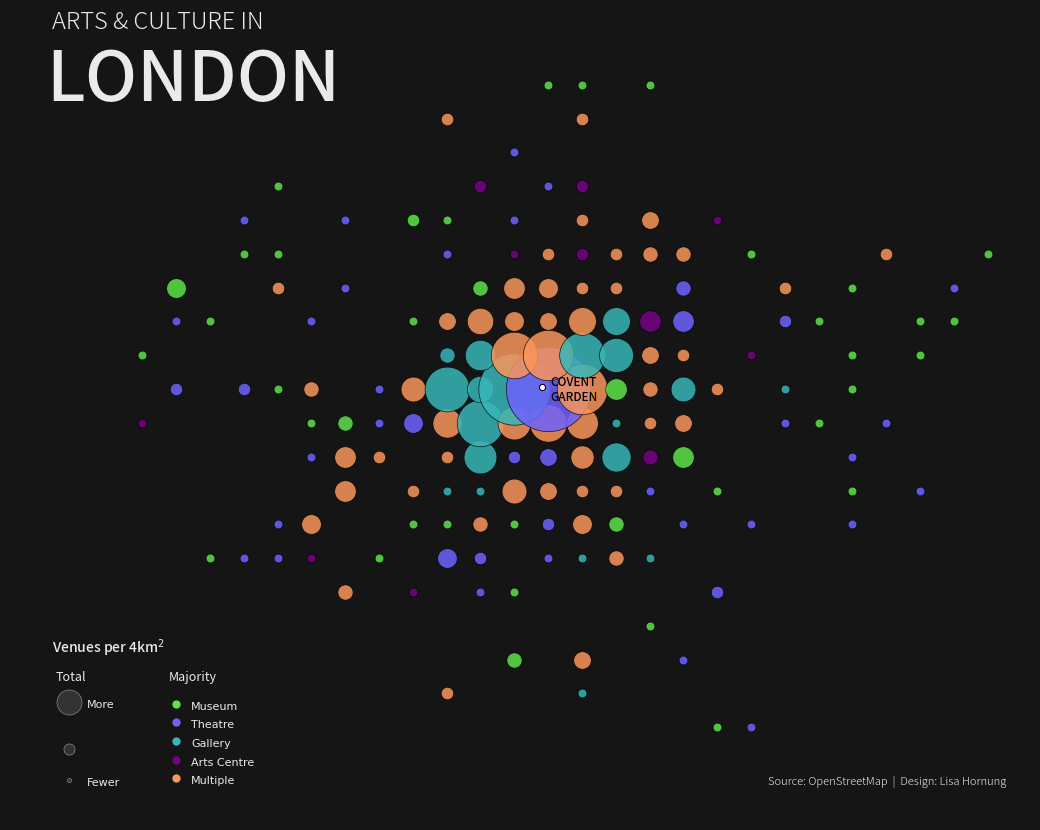

In [376]:
#plot
fig, ax = plt.subplots(figsize=(12, 12))

bg_color= "#EFEFEF"
bg_color="#151515"
font_color="#eaeaea"
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["total_venues"].iloc[i]*40, marker="o", color=colours[centroids["main_venue"].iloc[i]], 
               alpha=0.85, 
               edgecolor="black", clip_on=False, linewidth=0.5)

#plot covent garden
places.plot(ax=ax, markersize=20, color="white", edgecolor="black", linewidth=0.75, zorder=3,)
for i in range(len(places)):
    ax.text(places["geometry"].iloc[i].x+500, places["geometry"].iloc[i].y, places.index[i].upper(),
           fontproperties=title_font, va="center_baseline", ha="left", fontsize=8.5)

## Legend
lgd1 = fig.add_axes([0.15, 0.15, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=7, alpha=1,)
legend_elements = [Line2D([0], [0], markerfacecolor=colours["museum"], label="Museum", **kw), 
                  Line2D([0], [0], markerfacecolor=colours["theatre"], label="Theatre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["gallery"],label="Gallery",**kw),
                  Line2D([0], [0], markerfacecolor=colours["arts_centre"],label="Arts Centre", **kw),
                  Line2D([0], [0], markerfacecolor=colours["none"],label="Multiple", **kw),]
L = lgd1.legend(frameon=False, handles=legend_elements, loc='center', ncol=1, handletextpad=0.1)
plt.setp(L.texts,  size=8, va="baseline",color=font_color)    
lgd1.text(0.4, 0.895, "Majority", fontproperties=label_font, fontsize=9,  ha="center",color=font_color)

## second legend
lgd2 = fig.add_axes([0.05, 0.15, 0.13, 0.13]) 
kws = dict(marker='o', color=bg_color, markerfacecolor="#333333", markeredgecolor="#888888",markeredgewidth=0.5)
legend_elements2 = [Line2D([0], [0], markersize=18, label="More", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=0, label="", **kws),
                    Line2D([0], [0], markersize=8, label="", **kws), 
                    Line2D([0], [0], markersize=0, label="", **kws), 
                  Line2D([0], [0], markersize=3, label="Fewer", **kws)]
L = lgd2.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1,labelspacing=0.27, handletextpad=0.3,
               )
plt.setp(L.texts, size=8, va="baseline", color=font_color)    
lgd2.text(0.29, 0.895, "Total", fontproperties=label_font, fontsize=9,  ha="left",color=font_color)

#====
# Text
plt.figtext(0.085, 0.96-0.15 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=17,  ha="left",
           color=font_color)
plt.figtext(0.08, 0.9-0.15, "London".upper(), fontproperties=title_font, fontsize=50,  ha="left",color=font_color)
plt.figtext(0.88, 0.18, "Source: OpenStreetMap  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, 
            ha="right",color=font_color)
plt.figtext(0.085, 0.29, r"Venues per 4km$^2$", ha="left", fontproperties=title_font,size=10, color=font_color)

for axes in fig.axes:
    axes.axis("off")

#export
plt.savefig("london-arts-culture-creative-c.png", bbox_inches='tight', dpi=300, pad_inches=0.45, facecolor=bg_color)

plt.show()

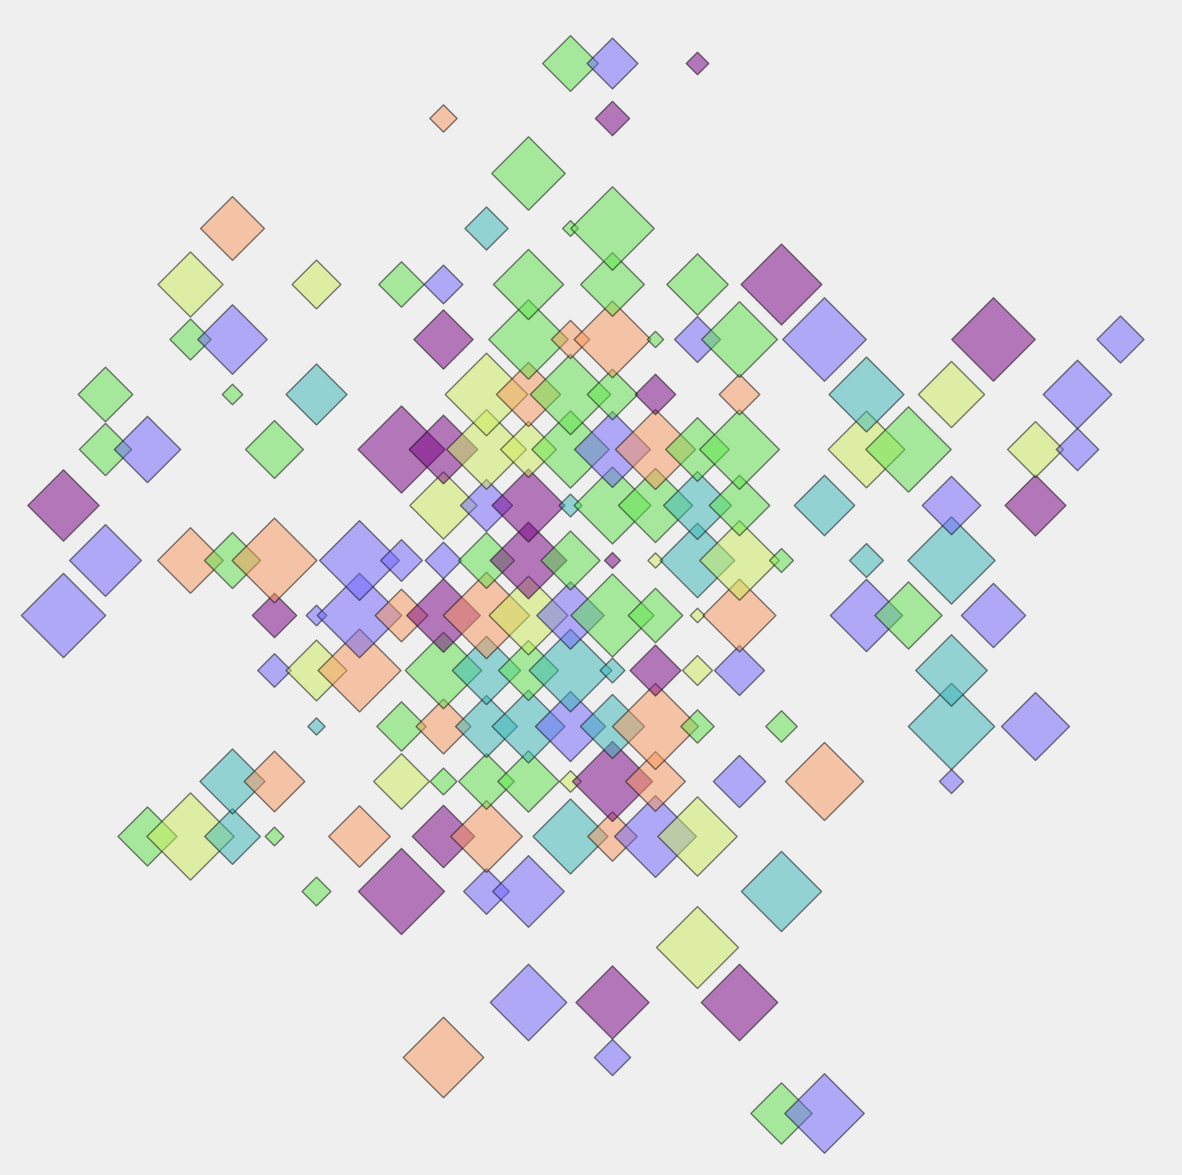

In [97]:

#plot
fig, ax = plt.subplots(figsize=(15, 15))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=random.randint(50, 2000), marker=random.choices(["D"], k=1)[0],
               color=centroids["colour"].iloc[i], alpha=0.5, 
               edgecolor="black", clip_on=False)

ax.axis("off")
plt.show()

Text(0.88, 0.15, 'Source: OSM  |  Design: Lisa Hornung')

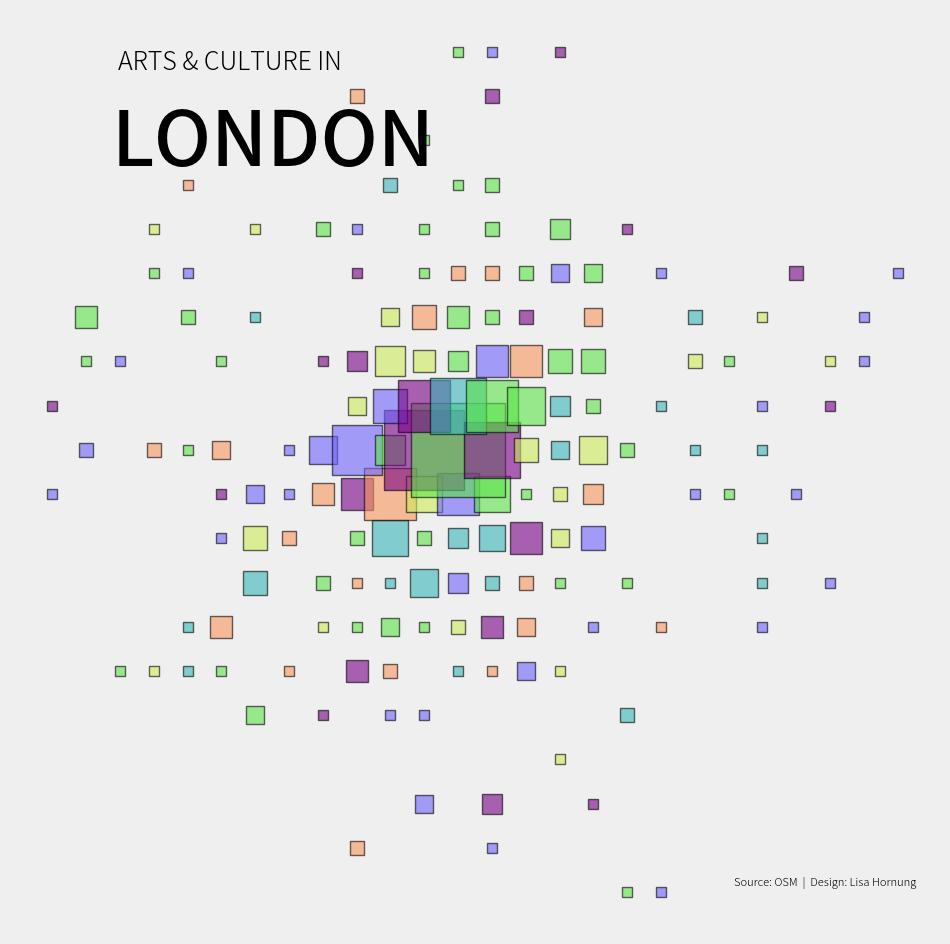

In [98]:

#plot
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["arts"].iloc[i]*50, marker="s", color=centroids["colour"].iloc[i], alpha=0.6, 
               edgecolor="black", clip_on=False)

ax.axis("off")

#====
# Text
plt.figtext(0.215, 0.88-0.05 , "Arts & culture in".upper(), fontproperties=subtitle_font, fontsize=18,  ha="left")
plt.figtext(0.21, 0.8-0.05, "London".upper(), fontproperties=title_font, fontsize=55,  ha="left")
plt.figtext(0.88, 0.15, "Source: OSM  |  Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="right")

## Playground

In [238]:
#dictionary of places to map
places = {#"Waterloo": [51.503097240913284, -0.11528864470447049], 
          "Liverpool St": [51.517633137766545, -0.08060437959423257],
          "Victoria": [51.495589500460675, -0.14321301504775705],
          #"Kings Cross/St Pancras":[51.53069350299307, -0.12337523753758314],
          #"Croydon":[51.37721502506337, -0.0978625631770451],
          #"Lewisham":[51.46544888638621, -0.013238946295010654],
          #"Stratford":[51.544869143315154, -0.008621849266683095],
          #"Hackney Central":[51.547200599288225, -0.05676321616862555],
          #"Brixton":[51.46262071532086, -0.11483407356841145],
         # "Hounslow Central":[51.47121316795325, -0.3670742932023845],
          #"North Acton":[51.5236004700105, -0.25919538834877026],
          #"Kingston":[51.412638145195736, -0.3009380954518059],
            #"Tottenham Hale":[51.58900890206423, -0.06005115905305452],
          #"Walthamstow":[51.59026047959829, -0.020566122447518747],
       # "Hampstead Heath":[51.555036448994414, -0.16618473613118084]
          
         }
places = pd.DataFrame.from_dict(places, orient="index", columns=["lat", "lon"])

geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = "4326", geometry = geometry)
places

,lat,lon,geometry
Liverpool St,51.517633,-0.080604,POINT (-0.08060 51.51763)
Victoria,51.495590,-0.143213,POINT (-0.14321 51.49559)


In [ ]:
#cmap = get_colormap(Buda_7_r.hex_colors, "#DADADA", int(fishnet["arts"].max()))

In [452]:
# played around with quite a few colour palettes before settling on one
from palettable.cartocolors.sequential import Magenta_7, PurpOr_5, Sunset_5, Teal_7, agGrnYl_5_r, BrwnYl_7, PinkYl_7, RedOr_7
from palettable.cmocean.sequential import Deep_14, Matter_20, Dense_20, Dense_5, Haline_10_r
from palettable.matplotlib import Magma_20_r
from palettable.scientific.sequential import Buda_7_r, Tokyo_8_r
from palettable.mycarta import Cube1_6_r

In [3]:
# amend colour palette so that the highest value = given background colour
def get_colormap(hex_colors, bg_color, max_value):
    listed_colormap = colors.LinearSegmentedColormap.from_list('colorpalette', hex_colors, N=max_value) 
    bg_color = np.array(colors.to_rgba(bg_color))
    newcolors = listed_colormap(np.linspace(0, 1, max_value))
    cmap_new = colors.ListedColormap(np.vstack((bg_color, newcolors)))
    return cmap_new